# Import and data loading

In [27]:
!pip install cmasher numpyro chainconsumer jaxopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
!gdown 1LGHpPp0KXnCRDtJD2alvyvaiNaJ7eDT3 # A3266 image from E-Rosita public data
!gdown 1PLvzBbae0EANWBLggqgwPDwecsx7sxLF # A3266 exposure map

Downloading...
From: https://drive.google.com/uc?id=1LGHpPp0KXnCRDtJD2alvyvaiNaJ7eDT3
To: /content/a3266_img_erosita.fits
100% 197M/197M [00:01<00:00, 163MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PLvzBbae0EANWBLggqgwPDwecsx7sxLF
To: /content/a3266_exp_erosita.fits
100% 42.5M/42.5M [00:00<00:00, 101MB/s] 


In [29]:
from jax.config import config
config.update("jax_enable_x64", True)
import numpyro

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import warnings
import cmasher as cmr
import numpyro.distributions as dist
from astropy.nddata import block_reduce
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.wcs import WCS
from jax import random
from jax.random import PRNGKey
from numpyro.infer import MCMC, NUTS



backend = jax.default_backend()

if backend == 'cpu':
    numpyro.set_host_device_count(4)
    chain_method = 'sequential'

else :
    chain_method = 'vectorized'

# Data from eRosita EDR



In this notebook, we will show you how to solve a Bayesian inference problem using numpyro and JAX. To do so, we will focus on fitting a surface brightness model to an X-ray image of the galaxy cluster Abell 3266, using the early data release of eRosita. Please be aware that solving a Bayesian inference problem using MCMC usually take a long time. To stay in a workshop timescale, we rebin the image to absurdly low number of pixels so that the MCMC is faster.

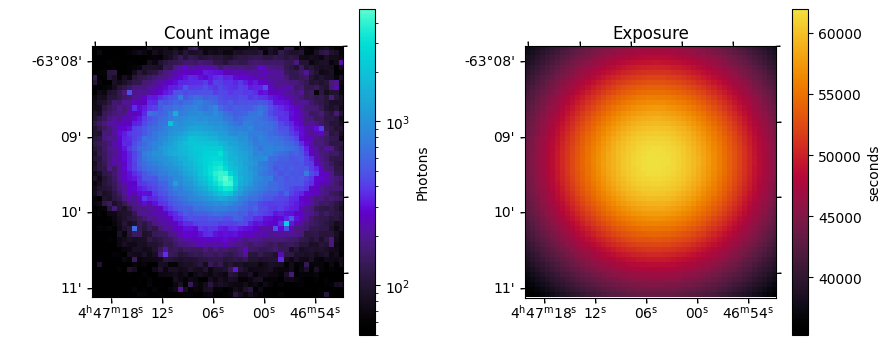

In [30]:
# Load the data

img_uncropped = fits.getdata('a3266_img_erosita.fits')
exp_uncropped = fits.getdata('a3266_exp_erosita.fits')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    wcs = WCS(header = fits.getheader('a3266_img_erosita.fits'), relax=True)

# Crop to the central parts

size = 200
x_min, y_min = 1620-size, 1620-size#coords.min(axis=0)
x_max, y_max = 1620+size, 1620+size#coords.max(axis=0)
img = img_uncropped[x_min:x_max+1, y_min:y_max+1]
exp = exp_uncropped[x_min:x_max+1, y_min:y_max+1]

# Rebin to lower number

img = block_reduce(img, 8, np.sum)
exp = block_reduce(exp, 8, np.mean)

# Display the data

plt.figure(figsize=(9,4))
ax = plt.subplot(121, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(img, norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Count image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(122, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(exp, cmap=cmr.ember)
plt.title('Exposure')
plt.colorbar(mappable=mappable, label='seconds')
plt.tight_layout()

# Surface Brightness Model

Here are the E-Rosita calibration images for the A3266 cluster of galaxies. For this example, we will determine an average emission model for this cluster. We choose the classical $\beta$-model [(Cavaliere & Fusco-Femiano, 1976)](https://ui-adsabs-harvard-edu.insu.bib.cnrs.fr/abs/1976A&A....49..137C/abstract) for this exercise. The $\beta$-model can describe either the surface brightness or the underlying density of the cluster, assuming spherical symmetry. It is expressed with the following equation :
$$
S_X(r) = S_{X,0} \left(1 + \left(\frac{r}{r_c}\right)^2\right)^{-\frac{3\beta}{2}}
$$

In the following cell, we show an implementation of this model which is numpy & JAX friendly, and plot the profile to show its shape.

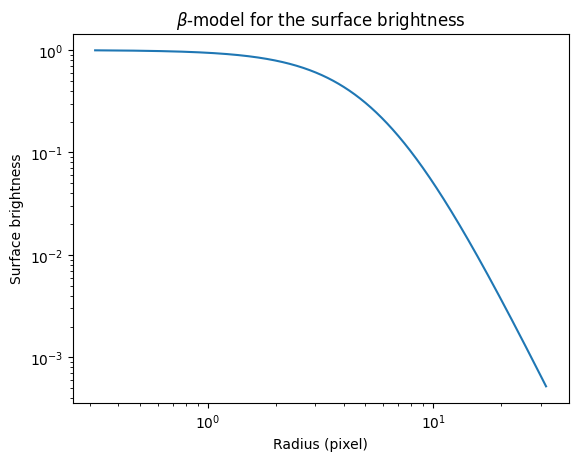

In [31]:
@jax.jit
def beta_model(r, **kwargs):
    """
    Implementation of a surface brightness beta-model
    """

    norm = jnp.float32(kwargs.get('norm', 1))
    r_c = jnp.float32(kwargs.get('r_c', 2*3.))
    beta = jnp.float32(kwargs.get('beta', 3/2))

    return norm*(1 + (r/r_c)**2)**(-3*beta/2)

# Plotting an example profile

r = jnp.logspace(-0.5, 1.5, 1000)

figure = plt.figure()
plt.plot(r, beta_model(r))
plt.title(r'$\beta$-model for the surface brightness')
plt.xlabel('Radius (pixel)')
plt.ylabel('Surface brightness')
plt.loglog();

This kind of model is often used either as a density model or a surface brightness model. For the sake of simplicity, we will fit a surface brightness model here using Bayesian inference. To do so, we must relate our model to the observable, which is here the number of counts in each pixel of the image. One can write the expected counts in each pixel as follows :

$$ \text{Counts} = (S_X + B) \times \text{Exposure} $$

The $B$ parameter represents a constant surface brightness background. In the following cell, we show an implementation for this model and how it can accurately describe the expected emission from the cluster.

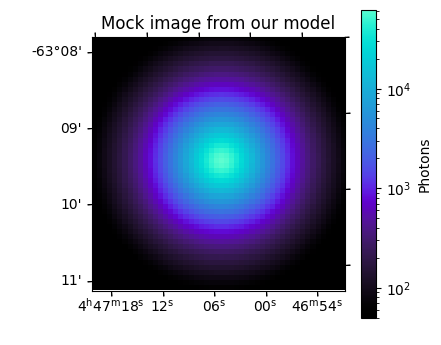

In [32]:
@jax.jit
def counts(exp, **kwargs):

    x, y = jnp.indices(exp.shape)

    x_c = jnp.float32(kwargs.get('x_c', exp.shape[0]//2))
    y_c = jnp.float32(kwargs.get('y_c', exp.shape[1]//2))
    bkg = jnp.float32(kwargs.get('bkg', 1e-6))

    r = jnp.hypot(x-x_c,y-y_c)

    sb = beta_model(r, **kwargs)

    return (sb + bkg)*jnp.float32(exp)


plt.figure(figsize=(9,4))
ax = plt.subplot(121, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(counts(exp), norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Mock image from our model')
plt.colorbar(mappable=mappable, label='Photons');

# Maximum likelihood estimation

In [33]:
import jaxopt

init_params = {
        'x_c': jnp.asarray(25.),
        'y_c': jnp.asarray(25.),
        'bkg': jnp.asarray(1e-7),
        'norm': jnp.asarray(0.05),
        'r_c': jnp.asarray(10.),
        'beta': jnp.asarray(3/2),
        }

low = {
        'x_c': jnp.asarray(15.),
        'y_c': jnp.asarray(15.),
        'bkg': jnp.asarray(0.),
        'norm': jnp.asarray(0.),
        'r_c': jnp.asarray(5.),
        'beta': jnp.asarray(0.),
        }

high = {
        'x_c': jnp.asarray(35.),
        'y_c': jnp.asarray(35.),
        'bkg': jnp.asarray(1e-3),
        'norm': jnp.asarray(1.),
        'r_c': jnp.asarray(20.),
        'beta': jnp.asarray(2.),
        }

@jax.jit
def loss(params):
    return -dist.Poisson(counts(exp, **params)).log_prob(img).sum()

solver = jaxopt.ScipyBoundedMinimize(fun=loss)
res = solver.run(init_params, bounds=(low, high))

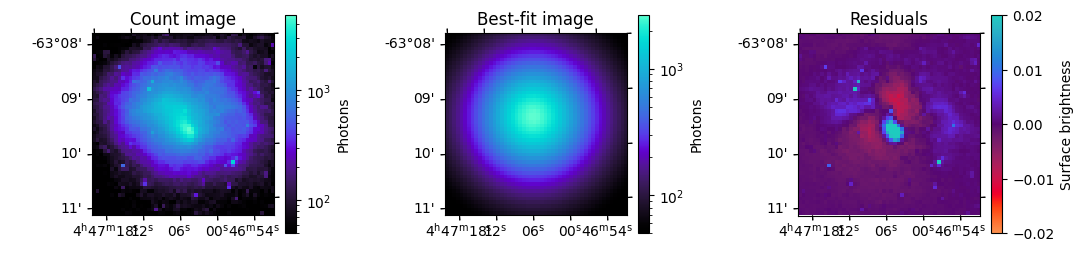

In [34]:
best_fit = res.params
best_fit_image = counts(exp, **best_fit)

plt.figure(figsize=(11,3))
ax = plt.subplot(131, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(img, norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Count image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(132, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(best_fit_image, norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Best-fit image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(133, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow((img-best_fit_image)/exp, cmap=cmr.guppy, vmin=-0.02, vmax=0.02)
plt.title('Residuals')
plt.colorbar(mappable=mappable, label='Surface brightness')
plt.tight_layout()

# Bayesian approach

## Running the MCMC

Now it is time to build our Bayesian model. This means we have to chose two things :
* A prior distribution for each of our parameters. These distributions will carry all the things we already know, and the aim of Bayesian inference is to reduce the spread of theses distributions by updating them with a new observation
* A likelihood function for our observables. This distribution represents what we expect from our observable, it carries both the link between the parameters of our model and our observable, and the expected errors.

Setting priors is a die and retry experience, since some tricky correlations can appear even if you have a good feeling about the set of each parameter. You may need to run several MCMC and update it.

The observable we have here is the number of count in each pixel of the image. Since it is a count/countrate task, it is well decribed using the Poisson law. The likelihood function $P(\theta~|~ x)$ is computed assuming a Poisson distribution in each pixel. For a given pixel , the probability of a parameter set is given by :

$$P(\theta~|~ x_i) = \frac{λ^{x_i}}{x_i !}e^{—\lambda}$$ where

*   $λ$ is the average count in pixel $i$ given by the model
*   $x_i$ is the observed number of photons in pixel $i$

With these two things set, it is easy to run an MCMC using the $\texttt{numpyro}$ package as we show in the following cell.

In [35]:
def model(img, exp):

    prior = {
        'x_c': numpyro.sample('x_c', dist.Normal(img.shape[0]/2, 1)),
        'y_c': numpyro.sample('y_c', dist.Normal(img.shape[1]/2, 1)),
        'bkg': numpyro.sample('bkg', dist.Exponential(1e7)),
        'norm': numpyro.sample('norm', dist.Exponential(1)),
        'r_c': numpyro.sample('r_c', dist.Uniform(0, 10)),
        'beta': numpyro.sample('beta', dist.Uniform(0., 2.))
        }

    numpyro.sample('likelihood',
                    dist.Poisson(counts(exp, **prior)),
                    obs=img)

num_samples=2000
num_chains=4

kernel = NUTS(model)

posterior = MCMC(kernel,
                 num_warmup=2000,
                 num_samples=num_samples,
                 num_chains=num_chains)

posterior.run(PRNGKey(0), img, exp)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

The MCMC sampling is over, if we managed to chose well the prior distributions, this low number of samples should be more than enough to describe our posterior distribution. Thanks to JAX, the likelihood is differentiable and it leverages the use of high efficiency samplers such as Hamiltonian Monte Carlo (HMC) or No U-Turn Sampler (NUTS) which achieve convergence of the chains in $≲ 10000$ steps. When using classical samplers such as $\texttt{emcee}$ takes one or two order of magnitude more samples to achieve the same thermalization of chains.

In [40]:
posterior_samples = posterior.get_samples(group_by_chain=True)

## Display the results

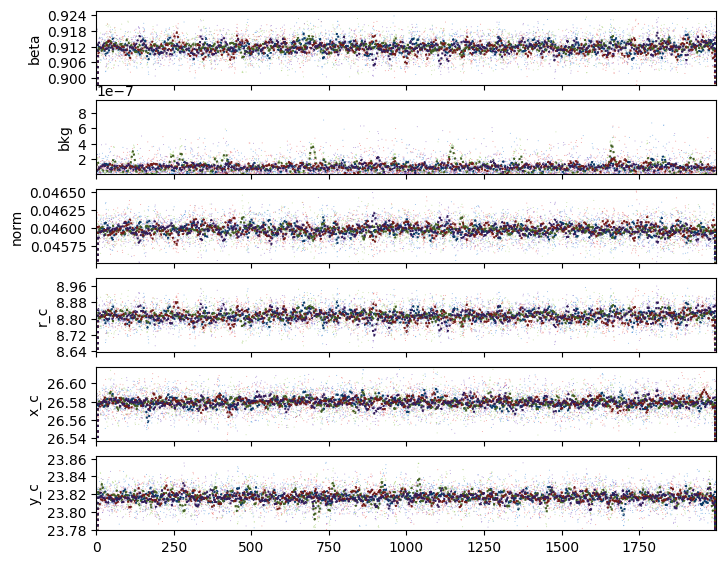

In [41]:
from chainconsumer import ChainConsumer

c = ChainConsumer()

for i in range(num_chains):
    c.add_chain({key:value[i, ...] for key, value in posterior_samples.items()})

c.configure(kde=True, shade_alpha=0.3)
fig = c.plotter.plot_walks(convolve=10)

Let's examinate the correlation between our parameters. Since the trace plot is stationary, we expect the parameters from each chain to be in perfect agreement.

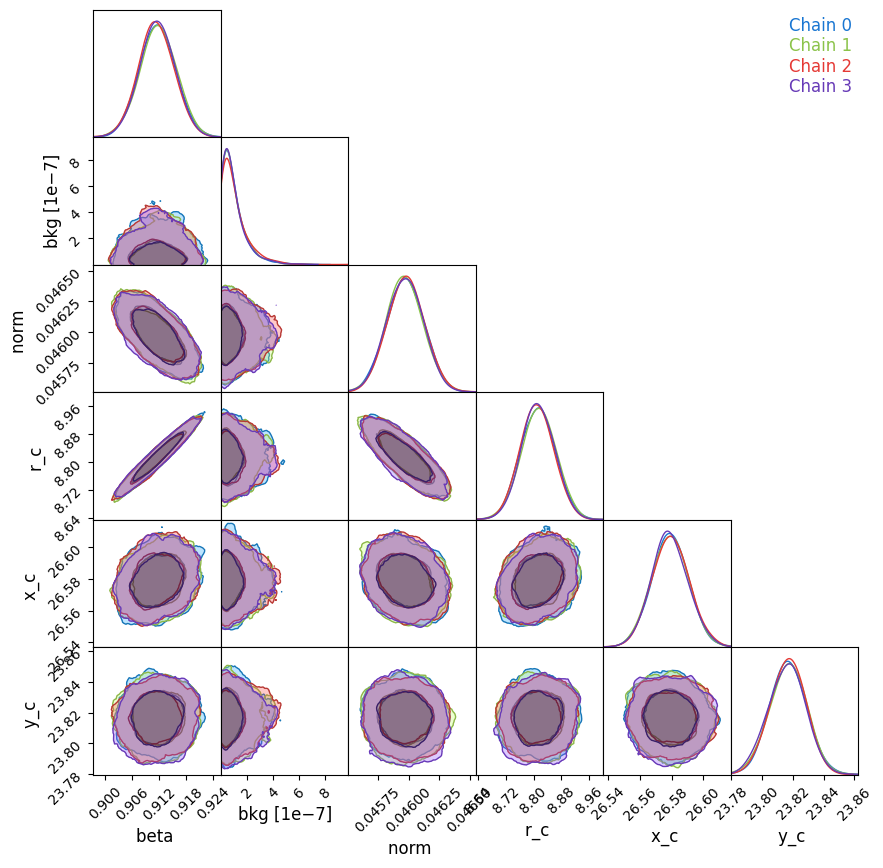

In [42]:
fig = c.plotter.plot()

Finally, since everything seems to be okay, we can plot the expected image using the maximum of the posterior distributions we just derived. Since each of the parameter posterior shows a Gaussian behavior, we can use the median of the samples to get a good approximation of the Maximum A Posteriori (MAP), which is the equivalent of the Maximum Likelihood Estimator but in a Bayesian framework.

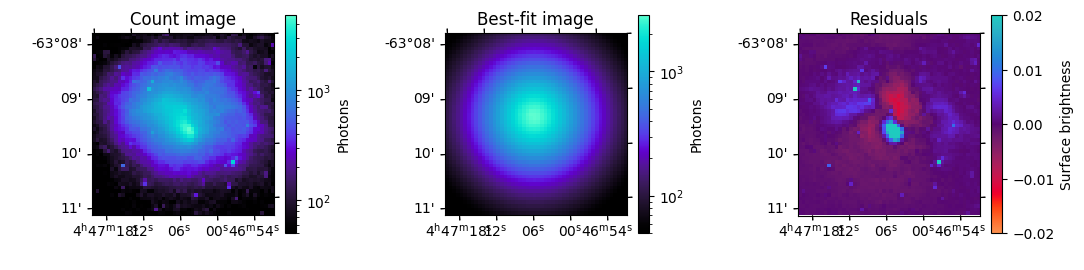

In [39]:
from jax.tree_util import tree_map

best_fit_median_params = jax.tree_map(jnp.median, posterior_samples)
best_fit_image = counts(exp, **best_fit_median_params)

plt.figure(figsize=(11,3))
ax = plt.subplot(131, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(img, norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Count image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(132, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow(best_fit_image, norm=LogNorm(vmin=5e1), cmap=cmr.cosmic)
plt.title('Best-fit image')
plt.colorbar(mappable=mappable, label='Photons')

ax = plt.subplot(133, projection=wcs)
ax.coords[0].set_axislabel(' ')
ax.coords[1].set_axislabel(' ')
mappable = ax.imshow((img-best_fit_image)/exp, cmap=cmr.guppy, vmin=-0.02, vmax=0.02)
plt.title('Residuals')
plt.colorbar(mappable=mappable, label='Surface brightness')
plt.tight_layout()